# 1. Libraries

In [1]:
# !pip install sklearn
# !pip install fancyimpute
# !pip install missingpy

In [2]:
import sklearn
print(sklearn.__version__)


1.2.2


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from fancyimpute import IterativeImputer as MICE
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import learning_curve


In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.model_selection import learning_curve

In [5]:
from sklearn.inspection import permutation_importance

In [7]:
all_train_losses = {}
all_val_losses = {}
all_train_accuracies = {}
all_val_accuracies = {}
epochsx = 12
# create a dictionary to store all the metrics
all_val_metrics = {
    'confusion_matrix': {},
    'classification_report': {}
}

In [18]:
from util.functions import snap_dataframe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from fancyimpute import IterativeImputer as MICE
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import learning_curve

imputation_methods = {
    'mean': SimpleImputer(strategy='mean'),
    'median': SimpleImputer(strategy='median'),
    'mode': SimpleImputer(strategy='most_frequent'),
    'KNN': KNNImputer(n_neighbors=2),
    'MICE': MICE(),
    'iterative': IterativeImputer(random_state=0),
}
models = {method: [] for method in imputation_methods}
metrics = {
    'accuracies': {method: [] for method in imputation_methods},
    'precisions': {method: [] for method in imputation_methods},
    'recalls': {method: [] for method in imputation_methods},
    'f1_scores': {method: [] for method in imputation_methods},
}
confusion_matrices = {method: [] for method in imputation_methods}

learning_curves = {method: [] for method in imputation_methods}
dataframes = {method: [] for method in imputation_methods}
# feature_importances = {}

dataframe = pd.read_csv('processed/df_numeric.csv')

for (impute_name, imputer) in imputation_methods.items():
    print(f'learning with {name} imputed data')

    # Define the number of desired cross-validation iterations
    num_cv_iterations = 5

    # Perform cross-validation iterations
    for i in range(num_cv_iterations):
        print('cv iteration {}/{}'.format(i + 1, num_cv_iterations))

        # Split the data into training and test sets
        train, test_1 = train_test_split(
            dataframe, test_size=0.2, random_state=42)

        # Perform imputation on the training set
        train_imputed = pd.DataFrame(train, columns=dataframe.columns)
        train_imputed[train_imputed.columns] = imputer.fit_transform(
            train)
        train_imputed = snap_dataframe(pd.DataFrame(train_imputed))

        # Drop NaN values from the test set
        test_dropped = test_1.dropna()

        # Train the model on the imputed training set
        ##############################
        
        val, test = train_test_split(test_dropped, test_size=0.5, random_state=42)

        class CKDDataset(Dataset):
            def __init__(self, data):
                self.data = torch.tensor(data.drop(columns='class').values, dtype=torch.float32)
                self.targets = torch.tensor(data['class'].values, dtype=torch.long)

            def __len__(self):
                return len(self.data)

            def __getitem__(self, idx):
                return self.data[idx], self.targets[idx]

        train_dataset = CKDDataset(train_imputed)
        train_loader = DataLoader(train_dataset, batch_size=16)

        val_dataset = CKDDataset(val)
        val_loader = DataLoader(val_dataset, batch_size=16)

        test_dataset = CKDDataset(test)
        test_loader = DataLoader(test_dataset, batch_size=16)

        # Define the network architecture
        class Net(nn.Module):
            def __init__(self):
                super(Net, self).__init__()

                self.fc1 = nn.Linear(24, 24)
                self.fc2 = nn.Linear(24, 2)
                self.dropout = nn.Dropout(0.2) # 20% dropout rate

            def forward(self, x):
                x = nn.functional.relu(self.fc1(x))
                x = self.dropout(x)
                x = self.fc2(x)
                return x

        # Initialize the network and define the loss function and optimizer
        model = Net()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Train the model
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(epochsx):
            model.train()
            train_loss = 0.0
            correct = total = 0
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

            train_acc = correct / total
            train_accuracies.append(train_acc)
            train_loss /= len(train_loader)
            train_losses.append(train_loss)

            # Validation phase
            model.eval()
            val_loss = 0.0
            correct_val = total_val = 0
            val_preds = []
            with torch.no_grad():
                for inputs, targets in val_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()
                    _, predicted = outputs.max(1)
                    val_preds.extend(predicted.tolist())
                    total_val += targets.size(0)
                    correct_val += predicted.eq(targets).sum()


            val_acc = correct_val / total_val
            val_loss /= len(val_loader)

            # Calculate confusion matrix and classification report
            cm = confusion_matrix(val['class'], np.array(val_preds))
            cr = classification_report(val['class'], np.array(val_preds), output_dict=True)

            all_val_metrics['confusion_matrix'][impute_name] = cm
            all_val_metrics['classification_report'][impute_name] = cr

            print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}, Train Acc: {train_acc:.3f}, Val Acc: {val_acc:.3f}')

        all_train_losses[impute_name] = train_losses
        all_val_losses[impute_name] = val_losses
        all_train_accuracies[impute_name] = train_accuracies
        all_val_accuracies[impute_name] = val_accuracies


learning with mean imputed data
cv iteration 1/5
Epoch: 1, Train Loss: 156.848, Val Loss: 136.744, Train Acc: 0.563, Val Acc: 0.500
Epoch: 2, Train Loss: 148.467, Val Loss: 79.987, Train Acc: 0.609, Val Acc: 0.500
Epoch: 3, Train Loss: 124.721, Val Loss: 95.041, Train Acc: 0.584, Val Acc: 0.500
Epoch: 4, Train Loss: 123.115, Val Loss: 95.695, Train Acc: 0.588, Val Acc: 0.500
Epoch: 5, Train Loss: 102.773, Val Loss: 43.345, Train Acc: 0.624, Val Acc: 0.500
Epoch: 6, Train Loss: 86.402, Val Loss: 64.484, Train Acc: 0.573, Val Acc: 0.500
Epoch: 7, Train Loss: 75.321, Val Loss: 72.491, Train Acc: 0.624, Val Acc: 0.500
Epoch: 8, Train Loss: 80.221, Val Loss: 47.795, Train Acc: 0.556, Val Acc: 0.500
Epoch: 9, Train Loss: 69.585, Val Loss: 45.861, Train Acc: 0.591, Val Acc: 0.500
Epoch: 10, Train Loss: 78.818, Val Loss: 42.829, Train Acc: 0.570, Val Acc: 0.500
Epoch: 11, Train Loss: 56.329, Val Loss: 36.906, Train Acc: 0.624, Val Acc: 0.500
Epoch: 12, Train Loss: 43.420, Val Loss: 26.036, Tra

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 9, Train Loss: 101.550, Val Loss: 60.425, Train Acc: 0.613, Val Acc: 0.500
Epoch: 10, Train Loss: 84.469, Val Loss: 73.575, Train Acc: 0.584, Val Acc: 0.500
Epoch: 11, Train Loss: 78.591, Val Loss: 55.729, Train Acc: 0.588, Val Acc: 0.500
Epoch: 12, Train Loss: 69.575, Val Loss: 67.913, Train Acc: 0.638, Val Acc: 0.500
cv iteration 3/5
Epoch: 1, Train Loss: 149.617, Val Loss: 62.126, Train Acc: 0.437, Val Acc: 0.500
Epoch: 2, Train Loss: 80.155, Val Loss: 80.166, Train Acc: 0.609, Val Acc: 0.500
Epoch: 3, Train Loss: 73.018, Val Loss: 31.864, Train Acc: 0.602, Val Acc: 0.500
Epoch: 4, Train Loss: 62.505, Val Loss: 48.557, Train Acc: 0.588, Val Acc: 0.500
Epoch: 5, Train Loss: 61.889, Val Loss: 51.952, Train Acc: 0.581, Val Acc: 0.500
Epoch: 6, Train Loss: 42.123, Val Loss: 19.711, Train Acc: 0.591, Val Acc: 0.500
Epoch: 7, Train Loss: 48.369, Val Loss: 42.894, Train Acc: 0.548, Val Acc: 0.500
Epoch: 8, Train Loss: 46.490, Val Loss: 33.646, Train Acc: 0.577, Val Acc: 0.500
Epoch:

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 7, Train Loss: 35.520, Val Loss: 33.425, Train Acc: 0.581, Val Acc: 0.500
Epoch: 8, Train Loss: 37.881, Val Loss: 21.095, Train Acc: 0.591, Val Acc: 0.500
Epoch: 9, Train Loss: 29.143, Val Loss: 17.634, Train Acc: 0.591, Val Acc: 0.500
Epoch: 10, Train Loss: 25.729, Val Loss: 20.125, Train Acc: 0.581, Val Acc: 0.500
Epoch: 11, Train Loss: 21.968, Val Loss: 15.936, Train Acc: 0.667, Val Acc: 0.500
Epoch: 12, Train Loss: 15.648, Val Loss: 13.754, Train Acc: 0.642, Val Acc: 0.500
cv iteration 5/5
Epoch: 1, Train Loss: 127.674, Val Loss: 88.846, Train Acc: 0.624, Val Acc: 0.500
Epoch: 2, Train Loss: 110.147, Val Loss: 46.421, Train Acc: 0.613, Val Acc: 0.500
Epoch: 3, Train Loss: 106.423, Val Loss: 45.358, Train Acc: 0.513, Val Acc: 0.500
Epoch: 4, Train Loss: 77.444, Val Loss: 51.354, Train Acc: 0.591, Val Acc: 0.500
Epoch: 5, Train Loss: 67.607, Val Loss: 47.244, Train Acc: 0.602, Val Acc: 0.500
Epoch: 6, Train Loss: 64.667, Val Loss: 20.859, Train Acc: 0.595, Val Acc: 0.500
Epoch

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 2, Train Loss: 70.638, Val Loss: 39.994, Train Acc: 0.559, Val Acc: 0.500
Epoch: 3, Train Loss: 74.188, Val Loss: 43.622, Train Acc: 0.538, Val Acc: 0.500
Epoch: 4, Train Loss: 51.692, Val Loss: 41.206, Train Acc: 0.620, Val Acc: 0.500
Epoch: 5, Train Loss: 42.758, Val Loss: 25.769, Train Acc: 0.631, Val Acc: 0.500
Epoch: 6, Train Loss: 31.376, Val Loss: 13.468, Train Acc: 0.606, Val Acc: 0.500
Epoch: 7, Train Loss: 27.260, Val Loss: 19.979, Train Acc: 0.559, Val Acc: 0.500
Epoch: 8, Train Loss: 22.969, Val Loss: 20.956, Train Acc: 0.649, Val Acc: 0.500
Epoch: 9, Train Loss: 18.735, Val Loss: 13.613, Train Acc: 0.584, Val Acc: 0.500
Epoch: 10, Train Loss: 14.246, Val Loss: 12.706, Train Acc: 0.570, Val Acc: 0.500
Epoch: 11, Train Loss: 12.062, Val Loss: 10.503, Train Acc: 0.613, Val Acc: 0.500
Epoch: 12, Train Loss: 7.629, Val Loss: 4.972, Train Acc: 0.631, Val Acc: 0.500
cv iteration 2/5
Epoch: 1, Train Loss: 63.796, Val Loss: 47.273, Train Acc: 0.620, Val Acc: 0.500
Epoch: 2, 

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 9, Train Loss: 7.461, Val Loss: 4.556, Train Acc: 0.606, Val Acc: 0.500
Epoch: 10, Train Loss: 5.617, Val Loss: 2.760, Train Acc: 0.620, Val Acc: 0.500
Epoch: 11, Train Loss: 2.962, Val Loss: 0.206, Train Acc: 0.656, Val Acc: 0.900
Epoch: 12, Train Loss: 1.795, Val Loss: 0.907, Train Acc: 0.670, Val Acc: 0.500
cv iteration 3/5
Epoch: 1, Train Loss: 65.239, Val Loss: 51.496, Train Acc: 0.563, Val Acc: 0.500
Epoch: 2, Train Loss: 43.448, Val Loss: 42.218, Train Acc: 0.652, Val Acc: 0.500
Epoch: 3, Train Loss: 35.943, Val Loss: 45.227, Train Acc: 0.624, Val Acc: 0.500
Epoch: 4, Train Loss: 39.852, Val Loss: 35.244, Train Acc: 0.627, Val Acc: 0.500
Epoch: 5, Train Loss: 37.943, Val Loss: 33.472, Train Acc: 0.581, Val Acc: 0.500
Epoch: 6, Train Loss: 28.802, Val Loss: 27.008, Train Acc: 0.602, Val Acc: 0.500
Epoch: 7, Train Loss: 25.093, Val Loss: 9.804, Train Acc: 0.595, Val Acc: 0.500
Epoch: 8, Train Loss: 17.302, Val Loss: 15.440, Train Acc: 0.631, Val Acc: 0.500
Epoch: 9, Train L

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 5, Train Loss: 58.273, Val Loss: 49.175, Train Acc: 0.577, Val Acc: 0.500
Epoch: 6, Train Loss: 49.912, Val Loss: 35.803, Train Acc: 0.556, Val Acc: 0.500
Epoch: 7, Train Loss: 53.919, Val Loss: 30.944, Train Acc: 0.552, Val Acc: 0.500
Epoch: 8, Train Loss: 33.649, Val Loss: 29.756, Train Acc: 0.609, Val Acc: 0.500
Epoch: 9, Train Loss: 27.757, Val Loss: 27.188, Train Acc: 0.624, Val Acc: 0.500
Epoch: 10, Train Loss: 27.987, Val Loss: 24.004, Train Acc: 0.609, Val Acc: 0.500
Epoch: 11, Train Loss: 23.044, Val Loss: 20.239, Train Acc: 0.609, Val Acc: 0.500
Epoch: 12, Train Loss: 25.749, Val Loss: 18.039, Train Acc: 0.602, Val Acc: 0.500
cv iteration 5/5
Epoch: 1, Train Loss: 102.975, Val Loss: 82.067, Train Acc: 0.516, Val Acc: 0.500
Epoch: 2, Train Loss: 76.211, Val Loss: 42.618, Train Acc: 0.595, Val Acc: 0.500
Epoch: 3, Train Loss: 62.057, Val Loss: 46.398, Train Acc: 0.591, Val Acc: 0.500
Epoch: 4, Train Loss: 62.049, Val Loss: 48.047, Train Acc: 0.609, Val Acc: 0.500
Epoch: 

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 6, Train Loss: 38.554, Val Loss: 30.890, Train Acc: 0.606, Val Acc: 0.500
Epoch: 7, Train Loss: 32.208, Val Loss: 36.220, Train Acc: 0.613, Val Acc: 0.500
Epoch: 8, Train Loss: 30.592, Val Loss: 30.264, Train Acc: 0.606, Val Acc: 0.500
Epoch: 9, Train Loss: 27.363, Val Loss: 19.038, Train Acc: 0.659, Val Acc: 0.500
Epoch: 10, Train Loss: 22.457, Val Loss: 14.272, Train Acc: 0.642, Val Acc: 0.500
Epoch: 11, Train Loss: 19.552, Val Loss: 22.499, Train Acc: 0.634, Val Acc: 0.500
Epoch: 12, Train Loss: 17.708, Val Loss: 15.271, Train Acc: 0.602, Val Acc: 0.500
learning with mean imputed data
cv iteration 1/5
Epoch: 1, Train Loss: 58.459, Val Loss: 57.071, Train Acc: 0.581, Val Acc: 0.500
Epoch: 2, Train Loss: 45.910, Val Loss: 17.097, Train Acc: 0.645, Val Acc: 0.500
Epoch: 3, Train Loss: 43.368, Val Loss: 23.560, Train Acc: 0.591, Val Acc: 0.500
Epoch: 4, Train Loss: 32.278, Val Loss: 29.919, Train Acc: 0.595, Val Acc: 0.500
Epoch: 5, Train Loss: 28.564, Val Loss: 24.089, Train Acc

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 2, Train Loss: 86.037, Val Loss: 19.413, Train Acc: 0.591, Val Acc: 0.500
Epoch: 3, Train Loss: 64.001, Val Loss: 25.265, Train Acc: 0.577, Val Acc: 0.500
Epoch: 4, Train Loss: 52.853, Val Loss: 30.738, Train Acc: 0.588, Val Acc: 0.500
Epoch: 5, Train Loss: 39.466, Val Loss: 8.792, Train Acc: 0.649, Val Acc: 0.500
Epoch: 6, Train Loss: 40.035, Val Loss: 20.371, Train Acc: 0.595, Val Acc: 0.500
Epoch: 7, Train Loss: 31.478, Val Loss: 16.543, Train Acc: 0.642, Val Acc: 0.500
Epoch: 8, Train Loss: 23.787, Val Loss: 22.853, Train Acc: 0.609, Val Acc: 0.500
Epoch: 9, Train Loss: 24.122, Val Loss: 21.383, Train Acc: 0.591, Val Acc: 0.500
Epoch: 10, Train Loss: 22.014, Val Loss: 10.558, Train Acc: 0.624, Val Acc: 0.500
Epoch: 11, Train Loss: 15.239, Val Loss: 12.498, Train Acc: 0.584, Val Acc: 0.500
Epoch: 12, Train Loss: 9.883, Val Loss: 9.153, Train Acc: 0.674, Val Acc: 0.500
cv iteration 3/5
Epoch: 1, Train Loss: 106.125, Val Loss: 68.074, Train Acc: 0.677, Val Acc: 0.500
Epoch: 2, 

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 10, Train Loss: 31.475, Val Loss: 7.186, Train Acc: 0.624, Val Acc: 0.500
Epoch: 11, Train Loss: 23.071, Val Loss: 9.217, Train Acc: 0.599, Val Acc: 0.500
Epoch: 12, Train Loss: 14.530, Val Loss: 10.372, Train Acc: 0.634, Val Acc: 0.500
cv iteration 4/5
Epoch: 1, Train Loss: 646.856, Val Loss: 231.452, Train Acc: 0.294, Val Acc: 0.500
Epoch: 2, Train Loss: 159.849, Val Loss: 68.469, Train Acc: 0.434, Val Acc: 0.500
Epoch: 3, Train Loss: 65.330, Val Loss: 84.074, Train Acc: 0.674, Val Acc: 0.500
Epoch: 4, Train Loss: 51.375, Val Loss: 22.964, Train Acc: 0.663, Val Acc: 0.500
Epoch: 5, Train Loss: 52.823, Val Loss: 42.400, Train Acc: 0.541, Val Acc: 0.500
Epoch: 6, Train Loss: 55.255, Val Loss: 31.801, Train Acc: 0.566, Val Acc: 0.500
Epoch: 7, Train Loss: 48.779, Val Loss: 37.023, Train Acc: 0.591, Val Acc: 0.500
Epoch: 8, Train Loss: 38.346, Val Loss: 15.828, Train Acc: 0.649, Val Acc: 0.500
Epoch: 9, Train Loss: 31.490, Val Loss: 30.167, Train Acc: 0.609, Val Acc: 0.500
Epoch: 

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 7, Train Loss: 42.913, Val Loss: 21.380, Train Acc: 0.581, Val Acc: 0.500
Epoch: 8, Train Loss: 30.933, Val Loss: 18.457, Train Acc: 0.634, Val Acc: 0.500
Epoch: 9, Train Loss: 29.488, Val Loss: 23.405, Train Acc: 0.581, Val Acc: 0.500
Epoch: 10, Train Loss: 27.044, Val Loss: 14.939, Train Acc: 0.613, Val Acc: 0.500
Epoch: 11, Train Loss: 20.031, Val Loss: 21.746, Train Acc: 0.602, Val Acc: 0.500
Epoch: 12, Train Loss: 14.571, Val Loss: 11.963, Train Acc: 0.649, Val Acc: 0.500
learning with mean imputed data
cv iteration 1/5
Epoch: 1, Train Loss: 145.813, Val Loss: 20.623, Train Acc: 0.649, Val Acc: 0.400
Epoch: 2, Train Loss: 113.396, Val Loss: 77.522, Train Acc: 0.556, Val Acc: 0.500
Epoch: 3, Train Loss: 105.369, Val Loss: 84.463, Train Acc: 0.573, Val Acc: 0.500


/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 4, Train Loss: 88.129, Val Loss: 50.062, Train Acc: 0.581, Val Acc: 0.500
Epoch: 5, Train Loss: 86.870, Val Loss: 56.931, Train Acc: 0.556, Val Acc: 0.500
Epoch: 6, Train Loss: 72.973, Val Loss: 49.128, Train Acc: 0.584, Val Acc: 0.500
Epoch: 7, Train Loss: 64.244, Val Loss: 29.969, Train Acc: 0.595, Val Acc: 0.500
Epoch: 8, Train Loss: 56.770, Val Loss: 46.487, Train Acc: 0.570, Val Acc: 0.500
Epoch: 9, Train Loss: 46.862, Val Loss: 26.824, Train Acc: 0.609, Val Acc: 0.500
Epoch: 10, Train Loss: 42.634, Val Loss: 24.908, Train Acc: 0.577, Val Acc: 0.500
Epoch: 11, Train Loss: 28.596, Val Loss: 20.096, Train Acc: 0.638, Val Acc: 0.500
Epoch: 12, Train Loss: 29.620, Val Loss: 25.391, Train Acc: 0.548, Val Acc: 0.500
cv iteration 2/5


/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 1, Train Loss: 114.761, Val Loss: 32.701, Train Acc: 0.545, Val Acc: 0.500
Epoch: 2, Train Loss: 100.713, Val Loss: 47.223, Train Acc: 0.599, Val Acc: 0.500
Epoch: 3, Train Loss: 86.576, Val Loss: 27.590, Train Acc: 0.563, Val Acc: 0.500
Epoch: 4, Train Loss: 52.605, Val Loss: 24.191, Train Acc: 0.638, Val Acc: 0.500
Epoch: 5, Train Loss: 51.150, Val Loss: 37.525, Train Acc: 0.595, Val Acc: 0.500
Epoch: 6, Train Loss: 47.157, Val Loss: 10.774, Train Acc: 0.577, Val Acc: 0.500
Epoch: 7, Train Loss: 44.077, Val Loss: 32.806, Train Acc: 0.559, Val Acc: 0.500
Epoch: 8, Train Loss: 30.859, Val Loss: 22.912, Train Acc: 0.634, Val Acc: 0.500
Epoch: 9, Train Loss: 29.918, Val Loss: 17.347, Train Acc: 0.588, Val Acc: 0.500
Epoch: 10, Train Loss: 23.212, Val Loss: 9.910, Train Acc: 0.616, Val Acc: 0.500
Epoch: 11, Train Loss: 17.953, Val Loss: 6.446, Train Acc: 0.652, Val Acc: 0.500
Epoch: 12, Train Loss: 14.608, Val Loss: 8.187, Train Acc: 0.652, Val Acc: 0.500
cv iteration 3/5


/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 1, Train Loss: 204.362, Val Loss: 133.843, Train Acc: 0.516, Val Acc: 0.500
Epoch: 2, Train Loss: 152.537, Val Loss: 123.160, Train Acc: 0.613, Val Acc: 0.500
Epoch: 3, Train Loss: 133.083, Val Loss: 97.828, Train Acc: 0.602, Val Acc: 0.500
Epoch: 4, Train Loss: 135.712, Val Loss: 54.948, Train Acc: 0.609, Val Acc: 0.500
Epoch: 5, Train Loss: 103.614, Val Loss: 74.041, Train Acc: 0.588, Val Acc: 0.500
Epoch: 6, Train Loss: 91.268, Val Loss: 71.909, Train Acc: 0.613, Val Acc: 0.500
Epoch: 7, Train Loss: 97.187, Val Loss: 59.629, Train Acc: 0.609, Val Acc: 0.500
Epoch: 8, Train Loss: 71.800, Val Loss: 61.011, Train Acc: 0.613, Val Acc: 0.500


/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 9, Train Loss: 68.233, Val Loss: 51.666, Train Acc: 0.624, Val Acc: 0.500
Epoch: 10, Train Loss: 61.628, Val Loss: 66.733, Train Acc: 0.545, Val Acc: 0.500
Epoch: 11, Train Loss: 60.855, Val Loss: 38.798, Train Acc: 0.631, Val Acc: 0.500
Epoch: 12, Train Loss: 56.127, Val Loss: 43.407, Train Acc: 0.577, Val Acc: 0.500
cv iteration 4/5
Epoch: 1, Train Loss: 87.541, Val Loss: 43.282, Train Acc: 0.552, Val Acc: 0.500
Epoch: 2, Train Loss: 56.512, Val Loss: 23.411, Train Acc: 0.638, Val Acc: 0.500
Epoch: 3, Train Loss: 51.656, Val Loss: 40.716, Train Acc: 0.566, Val Acc: 0.500
Epoch: 4, Train Loss: 39.830, Val Loss: 23.040, Train Acc: 0.616, Val Acc: 0.500


/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 5, Train Loss: 34.514, Val Loss: 15.343, Train Acc: 0.624, Val Acc: 0.500
Epoch: 6, Train Loss: 31.641, Val Loss: 28.122, Train Acc: 0.638, Val Acc: 0.500
Epoch: 7, Train Loss: 26.373, Val Loss: 12.758, Train Acc: 0.645, Val Acc: 0.500
Epoch: 8, Train Loss: 21.602, Val Loss: 18.144, Train Acc: 0.573, Val Acc: 0.500
Epoch: 9, Train Loss: 21.004, Val Loss: 13.992, Train Acc: 0.599, Val Acc: 0.500
Epoch: 10, Train Loss: 21.143, Val Loss: 14.860, Train Acc: 0.584, Val Acc: 0.500
Epoch: 11, Train Loss: 14.161, Val Loss: 10.199, Train Acc: 0.602, Val Acc: 0.500
Epoch: 12, Train Loss: 8.372, Val Loss: 9.012, Train Acc: 0.642, Val Acc: 0.500
cv iteration 5/5
Epoch: 1, Train Loss: 123.012, Val Loss: 49.514, Train Acc: 0.652, Val Acc: 0.500


/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 2, Train Loss: 121.704, Val Loss: 100.690, Train Acc: 0.577, Val Acc: 0.500
Epoch: 3, Train Loss: 80.626, Val Loss: 98.371, Train Acc: 0.670, Val Acc: 0.500
Epoch: 4, Train Loss: 85.568, Val Loss: 63.437, Train Acc: 0.591, Val Acc: 0.500
Epoch: 5, Train Loss: 94.202, Val Loss: 60.926, Train Acc: 0.573, Val Acc: 0.500
Epoch: 6, Train Loss: 70.586, Val Loss: 45.408, Train Acc: 0.631, Val Acc: 0.500
Epoch: 7, Train Loss: 60.090, Val Loss: 57.309, Train Acc: 0.616, Val Acc: 0.500
Epoch: 8, Train Loss: 58.325, Val Loss: 52.238, Train Acc: 0.591, Val Acc: 0.500
Epoch: 9, Train Loss: 51.657, Val Loss: 38.875, Train Acc: 0.613, Val Acc: 0.500
Epoch: 10, Train Loss: 42.588, Val Loss: 44.389, Train Acc: 0.620, Val Acc: 0.500
Epoch: 11, Train Loss: 43.826, Val Loss: 30.081, Train Acc: 0.595, Val Acc: 0.500
Epoch: 12, Train Loss: 32.655, Val Loss: 28.471, Train Acc: 0.591, Val Acc: 0.500
learning with mean imputed data
cv iteration 1/5


/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 1, Train Loss: 609.441, Val Loss: 246.693, Train Acc: 0.294, Val Acc: 0.500
Epoch: 2, Train Loss: 183.074, Val Loss: 30.360, Train Acc: 0.405, Val Acc: 0.500
Epoch: 3, Train Loss: 75.654, Val Loss: 84.447, Train Acc: 0.634, Val Acc: 0.500
Epoch: 4, Train Loss: 73.720, Val Loss: 49.761, Train Acc: 0.616, Val Acc: 0.500
Epoch: 5, Train Loss: 58.278, Val Loss: 29.090, Train Acc: 0.581, Val Acc: 0.500
Epoch: 6, Train Loss: 54.429, Val Loss: 48.889, Train Acc: 0.584, Val Acc: 0.500
Epoch: 7, Train Loss: 53.506, Val Loss: 34.959, Train Acc: 0.620, Val Acc: 0.500
Epoch: 8, Train Loss: 56.996, Val Loss: 37.712, Train Acc: 0.566, Val Acc: 0.500
Epoch: 9, Train Loss: 54.414, Val Loss: 26.703, Train Acc: 0.563, Val Acc: 0.500
Epoch: 10, Train Loss: 50.839, Val Loss: 23.357, Train Acc: 0.570, Val Acc: 0.500
Epoch: 11, Train Loss: 39.420, Val Loss: 32.272, Train Acc: 0.627, Val Acc: 0.500
Epoch: 12, Train Loss: 36.023, Val Loss: 18.301, Train Acc: 0.599, Val Acc: 0.500
cv iteration 2/5
Epoch

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 4, Train Loss: 92.409, Val Loss: 72.352, Train Acc: 0.627, Val Acc: 0.500
Epoch: 5, Train Loss: 101.413, Val Loss: 74.157, Train Acc: 0.606, Val Acc: 0.500
Epoch: 6, Train Loss: 74.271, Val Loss: 74.715, Train Acc: 0.606, Val Acc: 0.500
Epoch: 7, Train Loss: 81.264, Val Loss: 68.193, Train Acc: 0.649, Val Acc: 0.500
Epoch: 8, Train Loss: 87.803, Val Loss: 61.298, Train Acc: 0.577, Val Acc: 0.500
Epoch: 9, Train Loss: 68.803, Val Loss: 58.504, Train Acc: 0.634, Val Acc: 0.500
Epoch: 10, Train Loss: 81.010, Val Loss: 60.462, Train Acc: 0.588, Val Acc: 0.500
Epoch: 11, Train Loss: 74.399, Val Loss: 56.775, Train Acc: 0.581, Val Acc: 0.500
Epoch: 12, Train Loss: 73.888, Val Loss: 47.784, Train Acc: 0.548, Val Acc: 0.500
cv iteration 3/5


/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 1, Train Loss: 69.790, Val Loss: 62.635, Train Acc: 0.534, Val Acc: 0.500
Epoch: 2, Train Loss: 61.224, Val Loss: 42.963, Train Acc: 0.616, Val Acc: 0.500
Epoch: 3, Train Loss: 41.717, Val Loss: 4.459, Train Acc: 0.642, Val Acc: 0.300
Epoch: 4, Train Loss: 38.101, Val Loss: 34.363, Train Acc: 0.556, Val Acc: 0.500
Epoch: 5, Train Loss: 30.404, Val Loss: 13.962, Train Acc: 0.652, Val Acc: 0.500
Epoch: 6, Train Loss: 29.536, Val Loss: 22.139, Train Acc: 0.548, Val Acc: 0.500
Epoch: 7, Train Loss: 19.546, Val Loss: 6.431, Train Acc: 0.645, Val Acc: 0.500
Epoch: 8, Train Loss: 16.318, Val Loss: 13.688, Train Acc: 0.599, Val Acc: 0.500
Epoch: 9, Train Loss: 13.520, Val Loss: 16.035, Train Acc: 0.570, Val Acc: 0.500
Epoch: 10, Train Loss: 10.278, Val Loss: 9.710, Train Acc: 0.588, Val Acc: 0.500
Epoch: 11, Train Loss: 8.570, Val Loss: 8.502, Train Acc: 0.581, Val Acc: 0.500
Epoch: 12, Train Loss: 6.058, Val Loss: 5.379, Train Acc: 0.566, Val Acc: 0.500
cv iteration 4/5
Epoch: 1, Train

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 2, Train Loss: 78.410, Val Loss: 57.632, Train Acc: 0.606, Val Acc: 0.500
Epoch: 3, Train Loss: 53.753, Val Loss: 32.158, Train Acc: 0.624, Val Acc: 0.500
Epoch: 4, Train Loss: 48.142, Val Loss: 19.185, Train Acc: 0.577, Val Acc: 0.500
Epoch: 5, Train Loss: 37.693, Val Loss: 21.360, Train Acc: 0.627, Val Acc: 0.500
Epoch: 6, Train Loss: 32.373, Val Loss: 18.602, Train Acc: 0.638, Val Acc: 0.500
Epoch: 7, Train Loss: 25.662, Val Loss: 25.401, Train Acc: 0.581, Val Acc: 0.500
Epoch: 8, Train Loss: 24.470, Val Loss: 14.268, Train Acc: 0.591, Val Acc: 0.500
Epoch: 9, Train Loss: 14.997, Val Loss: 15.203, Train Acc: 0.627, Val Acc: 0.500
Epoch: 10, Train Loss: 17.030, Val Loss: 11.275, Train Acc: 0.599, Val Acc: 0.500
Epoch: 11, Train Loss: 8.785, Val Loss: 12.279, Train Acc: 0.670, Val Acc: 0.500
Epoch: 12, Train Loss: 9.913, Val Loss: 4.584, Train Acc: 0.638, Val Acc: 0.500
cv iteration 5/5
Epoch: 1, Train Loss: 237.700, Val Loss: 50.499, Train Acc: 0.434, Val Acc: 0.500
Epoch: 2, 

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 4, Train Loss: 99.636, Val Loss: 43.383, Train Acc: 0.609, Val Acc: 0.500
Epoch: 5, Train Loss: 104.936, Val Loss: 32.751, Train Acc: 0.591, Val Acc: 0.500
Epoch: 6, Train Loss: 73.168, Val Loss: 31.744, Train Acc: 0.599, Val Acc: 0.500
Epoch: 7, Train Loss: 73.886, Val Loss: 32.607, Train Acc: 0.602, Val Acc: 0.500
Epoch: 8, Train Loss: 80.972, Val Loss: 48.302, Train Acc: 0.563, Val Acc: 0.500
Epoch: 9, Train Loss: 61.906, Val Loss: 33.429, Train Acc: 0.595, Val Acc: 0.500
Epoch: 10, Train Loss: 55.100, Val Loss: 45.195, Train Acc: 0.613, Val Acc: 0.500
Epoch: 11, Train Loss: 55.471, Val Loss: 16.897, Train Acc: 0.563, Val Acc: 0.500
Epoch: 12, Train Loss: 42.304, Val Loss: 29.703, Train Acc: 0.602, Val Acc: 0.500
learning with mean imputed data
cv iteration 1/5
Epoch: 1, Train Loss: 236.536, Val Loss: 1.814, Train Acc: 0.341, Val Acc: 0.400
Epoch: 2, Train Loss: 79.499, Val Loss: 107.016, Train Acc: 0.606, Val Acc: 0.500
Epoch: 3, Train Loss: 85.916, Val Loss: 55.553, Train A

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 6, Train Loss: 52.118, Val Loss: 33.710, Train Acc: 0.613, Val Acc: 0.500
Epoch: 7, Train Loss: 52.130, Val Loss: 41.087, Train Acc: 0.577, Val Acc: 0.500
Epoch: 8, Train Loss: 47.336, Val Loss: 39.038, Train Acc: 0.627, Val Acc: 0.500
Epoch: 9, Train Loss: 40.791, Val Loss: 22.571, Train Acc: 0.634, Val Acc: 0.500
Epoch: 10, Train Loss: 32.585, Val Loss: 23.927, Train Acc: 0.609, Val Acc: 0.500
Epoch: 11, Train Loss: 31.011, Val Loss: 20.425, Train Acc: 0.616, Val Acc: 0.500
Epoch: 12, Train Loss: 35.661, Val Loss: 26.999, Train Acc: 0.552, Val Acc: 0.500
cv iteration 2/5
Epoch: 1, Train Loss: 336.354, Val Loss: 14.934, Train Acc: 0.358, Val Acc: 0.600
Epoch: 2, Train Loss: 173.106, Val Loss: 114.679, Train Acc: 0.559, Val Acc: 0.500
Epoch: 3, Train Loss: 170.654, Val Loss: 118.790, Train Acc: 0.591, Val Acc: 0.500
Epoch: 4, Train Loss: 134.809, Val Loss: 73.858, Train Acc: 0.645, Val Acc: 0.500
Epoch: 5, Train Loss: 159.917, Val Loss: 66.042, Train Acc: 0.577, Val Acc: 0.500
E

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 8, Train Loss: 98.835, Val Loss: 53.472, Train Acc: 0.609, Val Acc: 0.500
Epoch: 9, Train Loss: 90.961, Val Loss: 43.822, Train Acc: 0.577, Val Acc: 0.500
Epoch: 10, Train Loss: 87.528, Val Loss: 56.285, Train Acc: 0.581, Val Acc: 0.500
Epoch: 11, Train Loss: 76.579, Val Loss: 42.791, Train Acc: 0.624, Val Acc: 0.500
Epoch: 12, Train Loss: 66.965, Val Loss: 41.185, Train Acc: 0.606, Val Acc: 0.500
cv iteration 3/5
Epoch: 1, Train Loss: 152.803, Val Loss: 110.156, Train Acc: 0.584, Val Acc: 0.500
Epoch: 2, Train Loss: 127.079, Val Loss: 70.694, Train Acc: 0.588, Val Acc: 0.500
Epoch: 3, Train Loss: 124.364, Val Loss: 39.542, Train Acc: 0.595, Val Acc: 0.500
Epoch: 4, Train Loss: 86.740, Val Loss: 32.821, Train Acc: 0.616, Val Acc: 0.500
Epoch: 5, Train Loss: 91.888, Val Loss: 44.011, Train Acc: 0.559, Val Acc: 0.500
Epoch: 6, Train Loss: 83.725, Val Loss: 63.486, Train Acc: 0.548, Val Acc: 0.500
Epoch: 7, Train Loss: 61.179, Val Loss: 67.491, Train Acc: 0.599, Val Acc: 0.500
Epoc

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 10, Train Loss: 36.743, Val Loss: 30.862, Train Acc: 0.602, Val Acc: 0.500
Epoch: 11, Train Loss: 38.179, Val Loss: 22.740, Train Acc: 0.591, Val Acc: 0.500
Epoch: 12, Train Loss: 34.008, Val Loss: 28.023, Train Acc: 0.581, Val Acc: 0.500
cv iteration 4/5
Epoch: 1, Train Loss: 117.806, Val Loss: 81.183, Train Acc: 0.552, Val Acc: 0.500
Epoch: 2, Train Loss: 77.810, Val Loss: 55.701, Train Acc: 0.652, Val Acc: 0.500
Epoch: 3, Train Loss: 95.319, Val Loss: 87.299, Train Acc: 0.552, Val Acc: 0.500
Epoch: 4, Train Loss: 73.537, Val Loss: 26.895, Train Acc: 0.591, Val Acc: 0.500
Epoch: 5, Train Loss: 71.667, Val Loss: 75.854, Train Acc: 0.573, Val Acc: 0.500
Epoch: 6, Train Loss: 62.227, Val Loss: 27.595, Train Acc: 0.627, Val Acc: 0.500


/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 7, Train Loss: 47.673, Val Loss: 47.445, Train Acc: 0.652, Val Acc: 0.500
Epoch: 8, Train Loss: 47.408, Val Loss: 29.732, Train Acc: 0.591, Val Acc: 0.500
Epoch: 9, Train Loss: 33.440, Val Loss: 35.244, Train Acc: 0.659, Val Acc: 0.500
Epoch: 10, Train Loss: 29.196, Val Loss: 26.997, Train Acc: 0.616, Val Acc: 0.500
Epoch: 11, Train Loss: 27.898, Val Loss: 36.571, Train Acc: 0.616, Val Acc: 0.500
Epoch: 12, Train Loss: 25.063, Val Loss: 27.294, Train Acc: 0.620, Val Acc: 0.500
cv iteration 5/5
Epoch: 1, Train Loss: 122.756, Val Loss: 95.791, Train Acc: 0.541, Val Acc: 0.500
Epoch: 2, Train Loss: 110.017, Val Loss: 72.183, Train Acc: 0.595, Val Acc: 0.500
Epoch: 3, Train Loss: 93.429, Val Loss: 68.454, Train Acc: 0.584, Val Acc: 0.500
Epoch: 4, Train Loss: 89.313, Val Loss: 84.159, Train Acc: 0.631, Val Acc: 0.500
Epoch: 5, Train Loss: 83.696, Val Loss: 28.820, Train Acc: 0.602, Val Acc: 0.500
Epoch: 6, Train Loss: 75.495, Val Loss: 55.559, Train Acc: 0.577, Val Acc: 0.500
Epoch:

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

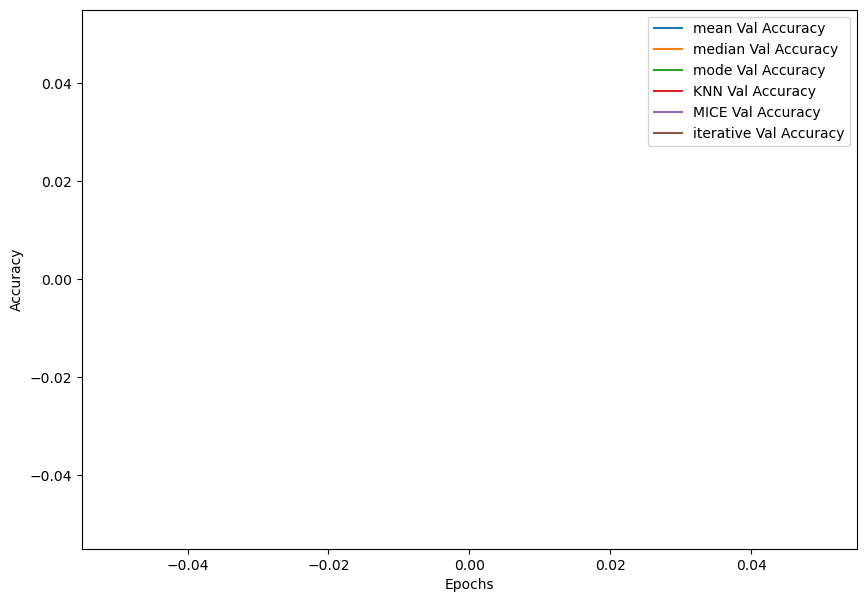

In [14]:
# Plotting train and validation accuracy
plt.figure(figsize=(10,7))
for impute_name in imputation_methods.keys():
    # plt.plot(all_train_accuracies[impute_name], label=f'{impute_name} Train Accuracy')
    plt.plot(all_val_accuracies[impute_name], label=f'{impute_name} Val Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

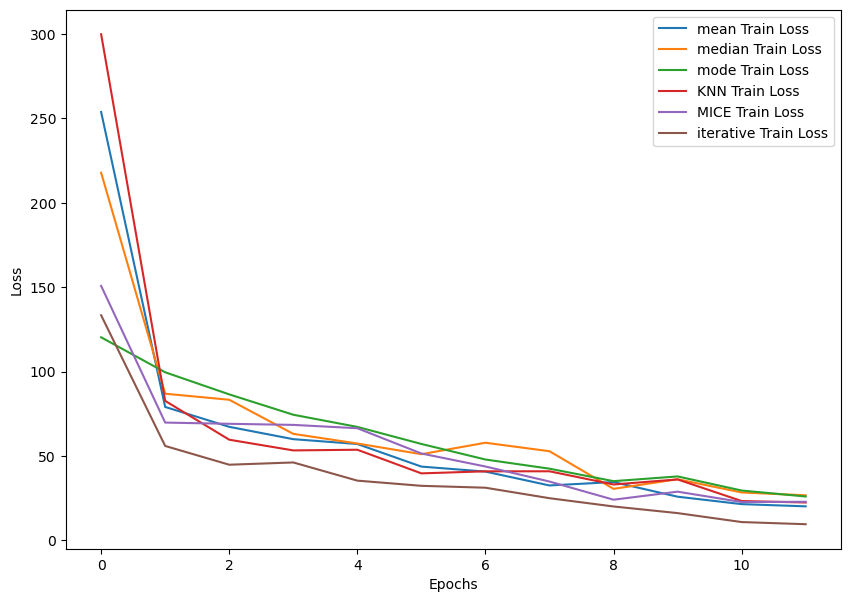

In [17]:
# Plotting train and validation loss
plt.figure(figsize=(10,7))
for impute_name in imputation_methods.keys():
    try:
        plt.plot(all_train_losses[impute_name], label=f'{impute_name} Train Loss')
        # plt.plot(all_val_losses[impute_name], label=f'{impute_name} Val Loss')
    except KeyError:
        print(f"No data for {impute_name} in train/val losses")

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 7. evaluate on the test set

In [ ]:
# Print metrics
for impute_name in imputation_methods.keys():
    try:
        print(f'For {impute_name} imputation:')
        print('Confusion Matrix:')
        print(all_val_metrics['confusion_matrix'][impute_name])
        print('Classification Report:')
        print(all_val_metrics['classification_report'][impute_name])
        print()
    except KeyError:
        print(f"No data for {impute_name} in validation metrics")

For mean imputation:
Confusion Matrix:
[[16  0]
 [ 3 33]]
Classification Report:
{'False': {'precision': 0.8421052631578947, 'recall': 1.0, 'f1-score': 0.9142857142857143, 'support': 16}, 'True': {'precision': 1.0, 'recall': 0.9166666666666666, 'f1-score': 0.9565217391304348, 'support': 36}, 'accuracy': 0.9423076923076923, 'macro avg': {'precision': 0.9210526315789473, 'recall': 0.9583333333333333, 'f1-score': 0.9354037267080746, 'support': 52}, 'weighted avg': {'precision': 0.951417004048583, 'recall': 0.9423076923076923, 'f1-score': 0.9435260391782131, 'support': 52}}

For median imputation:
Confusion Matrix:
[[16  0]
 [ 1 35]]
Classification Report:
{'False': {'precision': 0.9411764705882353, 'recall': 1.0, 'f1-score': 0.9696969696969697, 'support': 16}, 'True': {'precision': 1.0, 'recall': 0.9722222222222222, 'f1-score': 0.9859154929577464, 'support': 36}, 'accuracy': 0.9807692307692307, 'macro avg': {'precision': 0.9705882352941176, 'recall': 0.9861111111111112, 'f1-score': 0.9778